# OPTUNA & LGBM을 활용

In [1]:
!pip install lightgbm plotly optuna==0.18.1

In [1]:
import pandas as pd
import os
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold   # K-fold CV    
import json
import pickle


## 1. 데이터 로딩

In [2]:
data_dir = '/opt/p4-dkt-freshtomato/input/data/train_dataset'
# csv_file_path = os.path.join(data_dir, 'train_data.csv')
csv_file_path = os.path.join(data_dir, 'new_train_data.csv')
df = pd.read_csv(csv_file_path) 
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

## 2. Feature Engineering
### 추가적으로 생각해야할 변수들 (아직 추가 못함)
1. 유저가 똑같은 시험지를 여러번 보는가? 
    - 이 경우, test 유저도 똑같은 시험지를 여러번 보는 경우가 있는가?
    - 만약 그렇다면 (해당 시험지를 현재 몇번째로 보는 것인가?)를 변수로 쓸 수 있을 것이다.
1-2. 유저가 똑같은 문제를 여러번 보는가? 
    - 이 경우, test 유저도 똑같은 문제를 여러번 보는 경우가 있는가?
    - 만약 그렇다면 (해당 문제를 현재 몇번째로 보는 것인가?)를 변수로 쓸 수 있을 것이다.

2. 시험지 별로 총 시간제한이 있을 것이다
3. 문제를 몇 초, 몇 분만에 풀었는가 (다음 두개의 코드 참고)
    - df['db'] = df['b']-df['b'].shift(1)
    - df['db'] = df['b'].diff()
> 3번 코드 구현상의 문제점 : 해당 testid에 대하여 여러번 푼 적이 있는 사람에 대해서는 .groupby(['userid','testid']) 메소드를 사용해서 diff를 구할 수가 없다..

4. 현재 풀고 있는 문제와 같은 Knowledge Tag를 접한적이 있는가?
    - 여태까지 한 시험 내에서 같은 Tag를 몇번 접했는가
    - 여태까지 전체에서 같은 Tag를 몇번 접했는가
    - 해당 user는 전체적으로 해당 Tag와 같은 Tag를 몇번 접했는가
    - 같은 Tag를 접한지 이전으로부터 시간이 얼마나 지났는가
<!-- 5. KnowledgeTag 별 전체 정답률 -->
6. 한 시험지를 풂에 있어서 총 걸린 시간
7. 첫 문제를 풀기 시작한 시간으로부터 현재 문제를 풀기까지 경과시간
8. (현재 풀고있는) 해당 시험지를 푸는데 user들이 평균적으로 걸린 시간
    - 해당 시험지를 푸는데 user들이 걸린 시간들의 최대값, 최소값, 4분위수, 중앙값, 표준편차
9. (현재 풀고있는) 해당 문제를 푸는데 user들이 평균적으로 걸린 시간
    - 해당 문제를 푸는데 user들이 걸린 시간들의 최대값, 최소값, 4분위수, 중앙값, 표준편차
10. 해당 KnowledgeTag를 푸는데 user들이 평균적으로 걸린 시간
    - 해당 KnowledgeTag를 푸는데 user들이 걸린 시간들의 최대값, 최소값, 4분위수, 중앙값, 표준편차
11. 해당 시험지가 가지고 있는 KnowledgeTag의 개수
    - 같은 시험지면 등장한 KnowledgeTag의 개수가 같을까?
        - 만약 다르다면, 이것 역시 평균, 중앙값, 표준편차 등의 대표값들을 추출해내야 할듯

12. 이전까지 정답을 연속으로 몇번 맞혔는지 (누적카운팅)
13. 이전까지 정답을 연속으로 몇번 틀렸는지 (누적카운팅)
14. 직전에 정답을 맞혔는지 틀렸는지 여부 (binary 변수)


In [3]:
from feature_engineering import feature_engineering
def feature_engineering(df):

    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)

    # assessmentItemID (문제 ID)
    ## 문제의 식별번호 (범주형? 연속형?) - 9자리
    print('make feature : problem_id_num')
    df['problem_total_id'] = df['assessmentItemID'].map(lambda x: x[1:])
    ## 문제번호 (시험지 내에서) (범주형? 연속형?) - 3자리
    print('make feature : problem_num')
    df['problem_num'] = df['assessmentItemID'].map(lambda x: x[-3:])
    ## 시험지의 식별번호 전체 (범주형? 연속형?) - 6자리
    print('make feature : test_total_id')
    df['test_total_id'] = df['assessmentItemID'].map(lambda x: x[1:7])

    ###############################################
    # 해당 문제를 푸는데 몇 초가 걸렸는가 (연속형)
    print('make feature : time_solve_problem_in_test')
    new_df = df.copy()
    new_df['Timestamp'] = new_df['Timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ))
    df['time_solve_problem_in_test'] = new_df.groupby(['userID','testId']).apply(lambda x: x['Timestamp'].diff().shift(-1)).values
    del new_df

    ###############################################

    # UserID와 answerCode
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    # 유저의 총 정답 개수
    print('make feature : user_correct_answer')
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    # 유저의 풀이한 문제 누적합 개수
    print('make feature : user_total_answer')
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    # 유저의 정답률 변수
    print('make feature : user_acc')
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    
    # testId (시험 ID)
    ## 시험 난이도 변수 (연속형)
    print('make feature : test_level')
    df['test_level'] = df['testId'].map(lambda x: int(x[2]))   # A030071005 이 있으면, 030을 뽑아내는게 아니라 3만 뽑아냈음
    ## 시험 식별 아이디 뒷부분 (연속형? 범주형?)
    print('make feature : test_part_id')
    df['test_part_id'] = df['testId'].map(lambda x: x[-3:])   # A030071005 이 있으면, 030을 뽑아내는게 아니라 3만 뽑아냈음

    ## Timestamp(시간) 변수 활용
    # 연도
    print('make feature : year')
    df['year'] = df['Timestamp'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).year)
    # 요일 (범주형)
    print('make feature : day_of_week')
    df["day_of_week"] = df["Timestamp"].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).weekday())
    # 월 (범주형)
    print('make feature : month')
    df["month"] = df["Timestamp"].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month)
    # 몇번째 주인지 (범주형? 연속형?)
    print('make feature : week_number')
    df["week_number"] = df["Timestamp"].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).strftime('%V'))
    # 계절 변수 (범주형)
    print('make feature : season')
    seasons = [0,0,1,1,1,2,2,2,3,3,3,0] 
    df["season"] = df["Timestamp"].map(lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month-1)])
    # 시간대 (범주형? 연속형?)
    print('make feature : hour')
    df["hour"] = df["Timestamp"].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).hour)

    # KnowledgeTag
    print('make feature : slicing_ahead_KT')
    df['slicing_ahead1_KT_no_pad'] = df['KnowledgeTag'].map(lambda x: str(x)[:1])
    df['slicing_ahead2_KT_no_pad'] = df['KnowledgeTag'].map(lambda x: str(x)[:2])
    df['slicing_ahead3_KT_no_pad'] = df['KnowledgeTag'].map(lambda x: str(x)[:3])
    df['slicing_ahead3_KT_no_pad'] = df['KnowledgeTag'].map(lambda x: str(x)[:4])
    print('make feature : slicing_ahead_KT_with_pad')
    # df['slicing_ahead1_KT_with_pad'] = df['KnowledgeTag'].map(lambda x: str('0'*(5-len(str(x)))+str(x))[:1])
    df['slicing_ahead2_KT_with_pad'] = df['KnowledgeTag'].map(lambda x: str('0'*(5-len(str(x)))+str(x))[:2])
    df['slicing_ahead3_KT_with_pad'] = df['KnowledgeTag'].map(lambda x: str('0'*(5-len(str(x)))+str(x))[:3])
    df['slicing_ahead4_KT_with_pad'] = df['KnowledgeTag'].map(lambda x: str('0'*(5-len(str(x)))+str(x))[:4])

    ## 뒤에서부터도 슬라이싱해서 확인해보기
    print('make feature : slicing_behind_KT_no_pad')
    df['slicing_behind1_KT_no_pad'] = df['KnowledgeTag'].map(lambda x: str(x)[-1:])
    df['slicing_behind2_KT_no_pad'] = df['KnowledgeTag'].map(lambda x: str(x)[-2:])
    df['slicing_behind3_KT_no_pad'] = df['KnowledgeTag'].map(lambda x: str(x)[-3:])
    df['slicing_behind3_KT_no_pad'] = df['KnowledgeTag'].map(lambda x: str(x)[-4:])

    print('make feature : slicing_behind_KT_no_pad')
    df['slicing_behind1_KT_with_pad'] = df['KnowledgeTag'].map(lambda x: str('0'*(5-len(str(x)))+str(x))[-1:])
    df['slicing_behind2_KT_with_pad'] = df['KnowledgeTag'].map(lambda x: str('0'*(5-len(str(x)))+str(x))[-2:])
    df['slicing_behind3_KT_with_pad'] = df['KnowledgeTag'].map(lambda x: str('0'*(5-len(str(x)))+str(x))[-3:])
    df['slicing_behind4_KT_with_pad'] = df['KnowledgeTag'].map(lambda x: str('0'*(5-len(str(x)))+str(x))[-4:])


    # testId와 KnowledgeTag와 assessmentItemID에 대한 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    # 정답률, 정답개수, 총 풀이 개수
    # testId별로 정답률, 정답개수, 총 풀이 개수
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum', 'count'])
    correct_t.columns = ["test_mean", 'test_sum', 'test_count']
    # KnowledgeTag별로 정답률, 정답개수, 총 풀이 개수
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum', 'count'])
    correct_k.columns = ["tag_mean", 'tag_sum', 'tag_count']
    # assessmentItemID별로 정답률, 정답개수, 총 풀이 개수
    correct_ass = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum', 'count'])
    correct_ass.columns = ["problem_mean", 'problem_sum', 'problem_count']
    # user 별 총 풀이한 문제 개수
    correct_user = df.groupby(['userID'])['answerCode'].agg(['count'])
    correct_user.columns = ["user_total_problem"]

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, correct_ass, on=['assessmentItemID'], how="left")
    df = pd.merge(df, correct_user, on=['userID'], how="left")
    
    return df

In [4]:
df = feature_engineering(df)

make feature : problem_id_num
make feature : problem_num
make feature : test_total_id
make feature : time_solve_problem_in_test
make feature : user_correct_answer
make feature : user_total_answer
make feature : user_acc
make feature : test_level
make feature : test_part_id
make feature : year
make feature : day_of_week
make feature : month
make feature : week_number
make feature : season
make feature : hour
make feature : slicing_ahead_KT
make feature : slicing_ahead_KT_with_pad
make feature : slicing_behind_KT_no_pad
make feature : slicing_behind_KT_no_pad


In [20]:
# 따로 후처리 안했음.
df['time_solve_problem_in_test'] = df['time_solve_problem_in_test'].apply(lambda x: x.seconds)

In [21]:
df.dtypes[df.dtypes=='object']

assessmentItemID    object
testId              object
Timestamp           object
dtype: object

In [22]:
drop_features = ['assessmentItemID','testId','Timestamp']   # ,'userID'

cat_features = ['problem_total_id','problem_num','test_total_id','test_part_id','week_number',
                'slicing_ahead1_KT_no_pad','slicing_ahead2_KT_no_pad','slicing_ahead3_KT_no_pad',
                'slicing_ahead2_KT_with_pad','slicing_ahead3_KT_with_pad','slicing_ahead4_KT_with_pad',
                'slicing_behind1_KT_no_pad','slicing_behind2_KT_no_pad','slicing_behind3_KT_no_pad',
                'slicing_behind1_KT_with_pad','slicing_behind2_KT_with_pad','slicing_behind3_KT_with_pad','slicing_behind4_KT_with_pad']

df[cat_features] = df[cat_features].astype(int)

In [23]:
## hour의 구간(시간대)별로 어떤 영향이 있지 않을까?
# 0~5 : sleep, 6~9 : breakfast, 10~13 : morning routine, 14~17 : , 18~20 : , 21~23 : 
times_of_day = [0, 0, 0, 0, 0, 0,  1, 1, 1, 1,  2, 2, 2, 2,  3, 3, 3, 3,  4, 4, 4,  5, 5, 5 ]
time_of_day = lambda x: times_of_day[datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour]

# print('make feature : time_of_day')
# df["time_of_day"] = df["Timestamp"].map(time_of_day)

## 3. Train/Test 데이터 셋 분리

In [24]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [25]:
# from optuna.integration.lightgbm import LightGBMTunerCV
# import optuna.integration.lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import optuna                               # 베이지안 최적화 라이브러리  
from optuna import Trial
import lightgbm as lgb
import gc
import joblib


In [26]:
df_train = df.copy().drop(drop_features,axis=1)
# y_train = df_train['answerCode']
print(df_train.shape)

(2525956, 41)


In [27]:
seed = 42
early_stop = 100
num_rounds = 10000
folds=5
model_name='all_train_userid_time_diff_No_AfterProcess_lgbm_trial50'


In [28]:
def fit_lgbm_with_pruning(
                        trial, 
                        train, 
                        val, 
                        devices=(-1,), 
                        seed=seed, 
                        cat_features=cat_features, 
                        num_rounds=num_rounds,
                        early_stop=early_stop,
                        verbose_eval = 50,
                        ):

    X_train, y_train = train
    X_valid, y_valid = val

    """Train Light GBM model"""
    d_train = lgb.Dataset(X_train, label=y_train,
                        #   categorical_feature=cat_features,
                          )
    d_valid = lgb.Dataset(X_valid, label=y_valid,
                        #   categorical_feature=cat_features,
                          )
    watchlist = [d_train, d_valid]

    params = {
        'seed':seed,
        #'num_leaves': trial.suggest_int('num_leaves', 16,1e+4),     # 16~128 정도
        'objective': 'binary',

        'max_depth': trial.suggest_int('max_depth', 5,30),  # 8,30
        #'learning_rate': trial.suggest_discrete_uniform('learning_rate', 9e-3, 1e-2, 1e-5),   
        'learning_rate': trial.suggest_uniform('learning_rate',8e-3,0.1),
        "boosting": "gbdt",#'dart','goss',

        'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 25),   # 1~2     #'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 35),   # 3~6   #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),

        #"bagging_freq": 5,
        "bagging_fraction": trial.suggest_discrete_uniform('bagging_fraction', 0.05, 0.7, 0.05), 
        "feature_fraction": trial.suggest_discrete_uniform('feature_fraction', 0.05, 0.7, 0.05),  # 0.1, 0.5
        #"bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.35, 0.35),
        #"feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 0.4),  
        "metric": 'auc',
        # "metric": 'binary_logloss',

        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc', valid_name='valid_1')    
    print('training LGB:')
    model = lgb.train(
                    params,
                    train_set=d_train,
                    num_boost_round=num_rounds,
                    valid_sets=watchlist,
                    verbose_eval=verbose_eval,
                    early_stopping_rounds=early_stop,
                    callbacks=[pruning_callback],
                    # categorical_feature = cat_features,
                    categorical_feature = 'auto',
                    )

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)   # , cat_features=cat_features

    print('#'*25,'이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다.','#'*25)
    print('best_score', model.best_score)
    log = {'train_auc': model.best_score['training']['auc'],
           'valid_auc': model.best_score['valid_1']['auc']}
    return model, y_pred_valid, log

def objective_with_prune(
                        trial: Trial, 
                        seed=seed,
                        folds=folds,
                        cat_features=cat_features,
                        model_name=model_name):

    """This method is completely same with previous `objective` method except calling `fit_lgbm_with_pruning`"""

    gc.collect()
    print('='*100)
    # print('='*100)
    # print('cat_features : ', cat_features)
    model_upper_dir = f'../models/{folds}-fold_optuna_{model_name}'

    valid_score = 0
    fold_counter = 0
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    for train_idx, valid_idx in kf.split(df_train.groupby(['userID']), df_train.groupby(['userID'])):
        print("="*25, f"{fold_counter}번째 fold", "="*25)
        train_data = df_train.loc[df_train.userID.isin(train_idx),:]
        train_data = train_data.drop(['answerCode'],axis=1), train_data['answerCode'] 
        valid_data = df_train.loc[df_train.userID.isin(valid_idx),:]
        valid_data = valid_data.drop(['answerCode'],axis=1), valid_data['answerCode'] 

        print(f'train length : {train_data[0].shape[0]},  valid length : {valid_data[0].shape[0]}')
        # print(train_data[0].shape[0]+valid_data[0].shape[0])

        model, y_pred_valid, log = fit_lgbm_with_pruning(trial, train_data, valid_data,
                                                        # cat_features=cat_features,
                                                        num_rounds=num_rounds)

        gc.collect()

        # Save Model
        os.makedirs(f'{model_upper_dir}/{fold_counter}fold',exist_ok=True)
        joblib.dump(model, f'{model_upper_dir}/{fold_counter}fold/lgb.pkl')

        valid_score += log["valid_auc"]
        fold_counter += 1
    valid_score /= folds
    return valid_score


## 4. 훈련 및 검증

In [29]:
study = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner(n_warmup_steps=20))
study.optimize(objective_with_prune, n_trials=50)
# Best Params 저장
with open(f"../models/5-fold_optuna_{model_name}/best_params.json", "w") as fp:
        json.dump(study.best_params, fp, indent=4)

========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.792137	valid_1's auc: 0.788257
[300]	training's auc: 0.797376	valid_1's auc: 0.790981
[450]	training's auc: 0.80013	valid_1's auc: 0.791889
[600]	training's auc: 0.80246	valid_1's auc: 0.792179
[750]	training's auc: 0.804348	valid_1's auc: 0.792239
Early stopping, best iteration is:
[667]	training's auc: 0.803319	valid_1's auc: 0.792279
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8033188126574216)]), 'valid_1': OrderedDict([('auc', 0.7922790417015642)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	tr

[I 2021-05-28 21:33:35,269] Finished trial#0 resulted in value: 0.792451102434553. Current best value is 0.792451102434553 with parameters: {'max_depth': 16, 'learning_rate': 0.050671953554186085, 'lambda_l1': 1.518763655503233, 'lambda_l2': 31.722433922870845, 'bagging_fraction': 0.05, 'feature_fraction': 0.2}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.796952	valid_1's auc: 0.791412
[300]	training's auc: 0.801645	valid_1's auc: 0.792297
Early stopping, best iteration is:
[346]	training's auc: 0.802622	valid_1's auc: 0.792331
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.80262204833135)]), 'valid_1': OrderedDict([('auc', 0.792330689018973)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.797222	valid_1's auc: 0.790899
[300]	training's auc: 0.801864	valid_1's auc: 0.791614
[450]	training's auc: 0.80516	valid_1's auc: 0.791559
Early stop

[I 2021-05-28 21:44:18,310] Finished trial#1 resulted in value: 0.7926524478507286. Current best value is 0.7926524478507286 with parameters: {'max_depth': 7, 'learning_rate': 0.08714769065982761, 'lambda_l1': 8.956842098110462, 'lambda_l2': 31.820411050747754, 'bagging_fraction': 0.1, 'feature_fraction': 0.25}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.799641	valid_1's auc: 0.792626
Early stopping, best iteration is:
[179]	training's auc: 0.800841	valid_1's auc: 0.79272
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.800840778387536)]), 'valid_1': OrderedDict([('auc', 0.7927197768994597)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.800106	valid_1's auc: 0.791824
[300]	training's auc: 0.805427	valid_1's auc: 0.791762
Early stopping, best iteration is:
[205]	training's auc: 0.802289	valid_1's auc: 0.791961
######################### 이번

[I 2021-05-28 21:52:28,403] Finished trial#2 resulted in value: 0.7930019651186978. Current best value is 0.7930019651186978 with parameters: {'max_depth': 27, 'learning_rate': 0.09913797027575522, 'lambda_l1': 10.083838308923395, 'lambda_l2': 34.62550067193686, 'bagging_fraction': 0.55, 'feature_fraction': 0.6000000000000001}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798295	valid_1's auc: 0.792164
[300]	training's auc: 0.803365	valid_1's auc: 0.792517
Early stopping, best iteration is:
[275]	training's auc: 0.802626	valid_1's auc: 0.792588
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8026260285438575)]), 'valid_1': OrderedDict([('auc', 0.7925876112231475)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.79852	valid_1's auc: 0.791682
[300]	training's auc: 0.803822	valid_1's auc: 0.792016
Early stopping, best iteration is:
[256]	training's auc: 0.802

[I 2021-05-28 22:01:35,145] Finished trial#3 resulted in value: 0.7929432884126534. Current best value is 0.7930019651186978 with parameters: {'max_depth': 27, 'learning_rate': 0.09913797027575522, 'lambda_l1': 10.083838308923395, 'lambda_l2': 34.62550067193686, 'bagging_fraction': 0.55, 'feature_fraction': 0.6000000000000001}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.796368	valid_1's auc: 0.791865
[300]	training's auc: 0.800838	valid_1's auc: 0.792821
[450]	training's auc: 0.803965	valid_1's auc: 0.792955
Early stopping, best iteration is:
[466]	training's auc: 0.804229	valid_1's auc: 0.79297
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8042288883678917)]), 'valid_1': OrderedDict([('auc', 0.7929697523296549)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.796657	valid_1's auc: 0.79154
[300]	training's auc: 0.801041	valid_1's auc: 0.792269
Early st

[I 2021-05-28 22:14:14,199] Finished trial#4 resulted in value: 0.7932302683911349. Current best value is 0.7932302683911349 with parameters: {'max_depth': 13, 'learning_rate': 0.060726770566274624, 'lambda_l1': 17.72458584425072, 'lambda_l2': 26.923327016236897, 'bagging_fraction': 0.45, 'feature_fraction': 0.5}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:14:30,235] Setting status of trial#5 as TrialState.PRUNED. Trial was pruned at iteration 34.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:14:41,989] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:14:51,581] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:15:01,964] Setting status of trial#8 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:15:12,852] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:15:24,632] Setting status of trial#10 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.79809	valid_1's auc: 0.792557
[300]	training's auc: 0.802835	valid_1's auc: 0.792931
Early stopping, best iteration is:
[237]	training's auc: 0.80107	valid_1's auc: 0.792987
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8010699111926227)]), 'valid_1': OrderedDict([('auc', 0.7929874165391362)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798282	valid_1's auc: 0.791967
[300]	training's auc: 0.803123	valid_1's auc: 0.792133
Early stopping, best iteration is:
[273]	training's auc: 0.8023

[I 2021-05-28 22:24:45,006] Finished trial#11 resulted in value: 0.7932416004529312. Current best value is 0.7932416004529312 with parameters: {'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798019	valid_1's auc: 0.79244
[300]	training's auc: 0.802565	valid_1's auc: 0.792716
Early stopping, best iteration is:
[255]	training's auc: 0.801374	valid_1's auc: 0.792792
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8013737702948601)]), 'valid_1': OrderedDict([('auc', 0.7927922263197427)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798213	valid_1's auc: 0.79207
[300]	training's auc: 0.802973	valid_1's auc: 0.792286
Early stopping, best iteration is:
[323]	training's auc: 0.8035

[I 2021-05-28 22:33:16,069] Setting status of trial#12 as TrialState.PRUNED. Trial was pruned at iteration 474.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.797571	valid_1's auc: 0.792254
[300]	training's auc: 0.802318	valid_1's auc: 0.792782
Early stopping, best iteration is:
[325]	training's auc: 0.802953	valid_1's auc: 0.792813
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.802952963986007)]), 'valid_1': OrderedDict([('auc', 0.7928131667090542)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.797757	valid_1's auc: 0.791733
[300]	training's auc: 0.802709	valid_1's auc: 0.79217
[450]	training's auc: 0.806275	valid_1's auc: 0.792296


[I 2021-05-28 22:37:49,608] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at iteration 474.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798225	valid_1's auc: 0.792608
[300]	training's auc: 0.802996	valid_1's auc: 0.792871
Early stopping, best iteration is:
[314]	training's auc: 0.803353	valid_1's auc: 0.79291
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8033526662191349)]), 'valid_1': OrderedDict([('auc', 0.7929096049962769)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798296	valid_1's auc: 0.792128
Early stopping, best iteration is:
[180]	training's auc: 0.799401	valid_1's auc: 0.792348
######################### 이

[I 2021-05-28 22:48:20,937] Finished trial#14 resulted in value: 0.7932212215319396. Current best value is 0.7932416004529312 with parameters: {'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:48:32,383] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:48:43,387] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798498	valid_1's auc: 0.792733
[300]	training's auc: 0.803372	valid_1's auc: 0.792974
Early stopping, best iteration is:
[280]	training's auc: 0.80278	valid_1's auc: 0.793046
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8027799367753987)]), 'valid_1': OrderedDict([('auc', 0.7930461612048114)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.799106	valid_1's auc: 0.791906
Early stopping, best iteration is:
[188]	training's auc: 0.800447	valid_1's auc: 0.79212
######################### 이번

[I 2021-05-28 22:57:22,540] Finished trial#17 resulted in value: 0.7931412714153312. Current best value is 0.7932416004529312 with parameters: {'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:57:34,243] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:57:46,452] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 22:57:58,050] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798559	valid_1's auc: 0.792508
[300]	training's auc: 0.803421	valid_1's auc: 0.792996
Early stopping, best iteration is:
[280]	training's auc: 0.802893	valid_1's auc: 0.79304
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8028928184040833)]), 'valid_1': OrderedDict([('auc', 0.793039737474557)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798666	valid_1's auc: 0.792025
[300]	training's auc: 0.803824	valid_1's auc: 0.792114
Early stopping, best iteration is:
[222]	training's auc: 0.8012

[I 2021-05-28 23:06:58,555] Finished trial#21 resulted in value: 0.7932127914325915. Current best value is 0.7932416004529312 with parameters: {'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:07:10,641] Setting status of trial#22 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:07:46,283] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at iteration 93.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:07:58,208] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:08:10,102] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:08:22,071] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:08:34,302] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.800006	valid_1's auc: 0.792658


[I 2021-05-28 23:09:56,100] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at iteration 272.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:10:07,448] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:10:19,296] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:10:31,302] Setting status of trial#31 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:11:04,135] Setting status of trial#32 as TrialState.PRUNED. Trial was pruned at iteration 89.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:11:16,624] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.799088	valid_1's auc: 0.792555


[I 2021-05-28 23:12:07,163] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at iteration 152.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:12:18,221] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:12:30,128] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:12:42,894] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798967	valid_1's auc: 0.792605
[300]	training's auc: 0.803908	valid_1's auc: 0.792878
Early stopping, best iteration is:
[236]	training's auc: 0.80195	valid_1's auc: 0.79299
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8019501890460754)]), 'valid_1': OrderedDict([('auc', 0.7929895889780795)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.799161	valid_1's auc: 0.792045
[300]	training's auc: 0.804144	valid_1's auc: 0.79221
Early stopping, best iteration is:
[261]	training's auc: 0.80293

[I 2021-05-28 23:22:55,055] Finished trial#38 resulted in value: 0.7931862214662135. Current best value is 0.7932416004529312 with parameters: {'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:23:07,178] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.799669	valid_1's auc: 0.792805
[300]	training's auc: 0.804989	valid_1's auc: 0.792784
Early stopping, best iteration is:
[212]	training's auc: 0.80209	valid_1's auc: 0.792922
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8020904669743432)]), 'valid_1': OrderedDict([('auc', 0.7929216002398465)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.800044	valid_1's auc: 0.791781
[300]	training's auc: 0.805227	valid_1's auc: 0.791834
Early stopping, best iteration is:
[261]	training's auc: 0.803

[I 2021-05-28 23:32:14,484] Finished trial#40 resulted in value: 0.7930556115448362. Current best value is 0.7932416004529312 with parameters: {'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:32:28,155] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at iteration 24.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:33:14,092] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at iteration 121.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798859	valid_1's auc: 0.792663
[300]	training's auc: 0.80398	valid_1's auc: 0.792915
Early stopping, best iteration is:
[268]	training's auc: 0.802931	valid_1's auc: 0.792985
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.802931281383727)]), 'valid_1': OrderedDict([('auc', 0.7929848260085027)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.799305	valid_1's auc: 0.792118
[300]	training's auc: 0.804504	valid_1's auc: 0.792381
Early stopping, best iteration is:
[273]	training's auc: 0.8035

[I 2021-05-28 23:43:20,627] Finished trial#43 resulted in value: 0.7932380452939316. Current best value is 0.7932416004529312 with parameters: {'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:43:32,392] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:43:44,410] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-28 23:43:56,485] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 21.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798804	valid_1's auc: 0.792803
[300]	training's auc: 0.803894	valid_1's auc: 0.79309
Early stopping, best iteration is:
[275]	training's auc: 0.803226	valid_1's auc: 0.793113
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8032255982394457)]), 'valid_1': OrderedDict([('auc', 0.7931131895176299)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.799238	valid_1's auc: 0.791957
[300]	training's auc: 0.804152	valid_1's auc: 0.792243
Early stopping, best iteration is:
[266]	training's auc: 0.803

[I 2021-05-28 23:54:06,382] Finished trial#47 resulted in value: 0.793240484176678. Current best value is 0.7932416004529312 with parameters: {'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.799379	valid_1's auc: 0.792708
[300]	training's auc: 0.804811	valid_1's auc: 0.7928
Early stopping, best iteration is:
[211]	training's auc: 0.801857	valid_1's auc: 0.792961
######################### 이번 trial의 fold 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8018572306526757)]), 'valid_1': OrderedDict([('auc', 0.7929614657067988)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.799838	valid_1's auc: 0.792006
Early stopping, best iteration is:
[186]	training's auc: 0.801327	valid_1's auc: 0.792146
######################### 이번

[I 2021-05-29 00:02:10,265] Finished trial#48 resulted in value: 0.7930816091572118. Current best value is 0.7932416004529312 with parameters: {'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}.


========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2021-05-29 00:02:22,381] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at iteration 21.


### 4-2. 가장 마지막 trial로부터 저장된 모델로 inference하기

In [ ]:
### 가장 마지막에 저장된 모델을 가지고 Inference

# LOAD TEST_DATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

test_df[cat_features] = test_df[cat_features].astype(int)

# Load Model
total_preds=[]
upper_model_dir = '/opt/p4-dkt-freshtomato/models/5-fold_optuna_all_train_userid_lgbm'
folders_list = os.listdir(upper_model_dir)
for folder_name in folders_list:
    model_path = f"{upper_model_dir}/{folder_name}/lgb.pkl"
    load_model = joblib.load(model_path)
    prediction = load_model.predict(test_df.drop(drop_features,axis=1))
    total_preds.append(prediction)
    
total_preds = np.array(total_preds).mean(axis=0)

# SAVE OUTPUT
output_dir = '../output/lgbm_output/'
write_path = os.path.join(output_dir, f"{upper_model_dir.split('/')[-1]}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

## 5. 찾아낸 최적의 모수로 모델 피팅시키기

In [33]:
def fit_lgbm(
            trial, 
            train, 
            val, 
            devices=(-1,), 
            seed=seed, 
            num_rounds=num_rounds,
            early_stop=early_stop,
            cat_features = cat_features
            ):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val

    d_train = lgb.Dataset(X_train, label=y_train,
                        # categorical_feature=cat_features
                        )
    d_valid = lgb.Dataset(X_valid, label=y_valid,
                        # categorical_feature=cat_features
                        )
    watchlist = [d_train, d_valid]

    params = {
        'seed':seed,
        #'num_leaves': trial.suggest_int('num_leaves', 8, 1024),
        'objective': 'binary',
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-10, 0.1),
        "boosting": "gbdt",#'dart','goss'
        #'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 50), 
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 50),
        #"bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0, 1),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0, 1),
        "metric": 'auc',
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    verbose_eval = 150


    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                    #   categorical_feature=cat_features,
                      categorical_feature='auto',
                      )

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/auc': model.best_score['training']['auc'],
           'valid/auc': model.best_score['valid_1']['auc']}
    return model, y_pred_valid, log


def objective(
            trial: Trial, 
            fast_check=True,  
            return_info=False,
            seed=seed,
            folds=folds,
            cat_features = cat_features
            ):
    folds = folds
    seed = seed
    shuffle = True

    gc.collect()
    print('='*100)

    # print('cat_features', cat_features)
    models_list = []
    y_train = []
    y_valid = []
    valid_score = 0
    fold_counter = 0
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
    for train_idx, valid_idx in kf.split(df_train.groupby(['userID']), df_train.groupby(['userID'])):
        print("="*25, f"{fold_counter}번째 fold", "="*25)
        train_data = df_train.loc[df_train.userID.isin(train_idx),:]
        y_train.append(train_data['answerCode'])
        train_data = train_data.drop(['answerCode'],axis=1), train_data['answerCode'] 
    
        valid_data = df_train.loc[df_train.userID.isin(valid_idx),:]
        y_valid.append(valid_data['answerCode'])
        valid_data = valid_data.drop(['answerCode'],axis=1), valid_data['answerCode'] 

        print(f'train length : {train_data[0].shape[0]},  valid length : {valid_data[0].shape[0]}')

        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data,
                                            # cat_features=cat_features,
                                            num_rounds=num_rounds)
        models_list.append(model)
        gc.collect()
        valid_score += log["valid/auc"]
        fold_counter+=1
        if fast_check:
            break
    valid_score /= folds
    if return_info:
        return valid_score, models_list, y_train, y_valid
    else:
        return valid_score


In [34]:
print(study.best_params)

{'max_depth': 30, 'learning_rate': 0.07111961859920349, 'lambda_l1': 11.080862756420968, 'lambda_l2': 34.491702962288315, 'bagging_fraction': 0.5, 'feature_fraction': 0.7}


In [35]:
valid_score, models_list, y_train, y_valid = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, return_info=True)

========================= 0번째 fold =========================
train length : 2000157,  valid length : 525799
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.79809	valid_1's auc: 0.792557
[300]	training's auc: 0.802835	valid_1's auc: 0.792931
Early stopping, best iteration is:
[237]	training's auc: 0.80107	valid_1's auc: 0.792987
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8010699111926227)]), 'valid_1': OrderedDict([('auc', 0.7929874165391362)])})
========================= 1번째 fold =========================
train length : 2008829,  valid length : 517127
training LGB:
Training until validation scores don't improve for 100 rounds
[150]	training's auc: 0.798282	valid_1's auc: 0.791967
[300]	training's auc: 0.803123	valid_1's auc: 0.792133
Early stopping, best iteration is:
[273]	training's auc: 0.802329	valid_1's auc: 0.792204
best_score defaultdict(<class 'collections.OrderedDict'>, {'tra

In [37]:

# LOAD TEST_DATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)
test_df['time_solve_problem_in_test'] = test_df['time_solve_problem_in_test'].apply(lambda x: x.seconds)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

test_df[cat_features] = test_df[cat_features].astype(int)


total_preds = []
for model in models_list:
    pred = model.predict(test_df.drop(drop_features,axis=1))
    total_preds.append(pred)
total_preds = np.mean(total_preds, axis=0)


make feature : problem_id_num
make feature : problem_num
make feature : test_total_id
make feature : time_solve_problem_in_test
make feature : user_correct_answer
make feature : user_total_answer
make feature : user_acc
make feature : test_level
make feature : test_part_id
make feature : year
make feature : day_of_week
make feature : month
make feature : week_number
make feature : season
make feature : hour
make feature : slicing_ahead_KT
make feature : slicing_ahead_KT_with_pad
make feature : slicing_behind_KT_no_pad
make feature : slicing_behind_KT_no_pad


In [38]:
upper_model_dir = '5-fold_optuna_all_train_userid_lgbm_trial50_문제풀이간격후처리X'
# SAVE OUTPUT
output_dir = '../output/lgbm_output/'
write_path = os.path.join(output_dir, f"{upper_model_dir.split('/')[-1]}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : ../output/lgbm_output/5-fold_optuna_all_train_userid_lgbm_trial50_문제풀이간격후처리X.csv


## 6. Visualization of Modeling

In [ ]:
fig,ax = plt.subplots(len(models_list)//2,2)

ax[0].plot(x,y1,'r-*',lw=1)
ax[0].grid(True)
ax[0].set_ylabel(r'$sin(4 \pi x)$')
ax[0].axis([0,1,-1.5,1.5])

ax[1].plot(x,y2,'b--o',lw=1)
ax[1].grid(True)
ax[1].set_xlabel('x')
ax[1].set_ylabel(r'$ e^{-2x} sin(4\pi x) $')
ax[1].axis([0,1,-1.5,1.5])

plt.tight_layout()
plt.show()

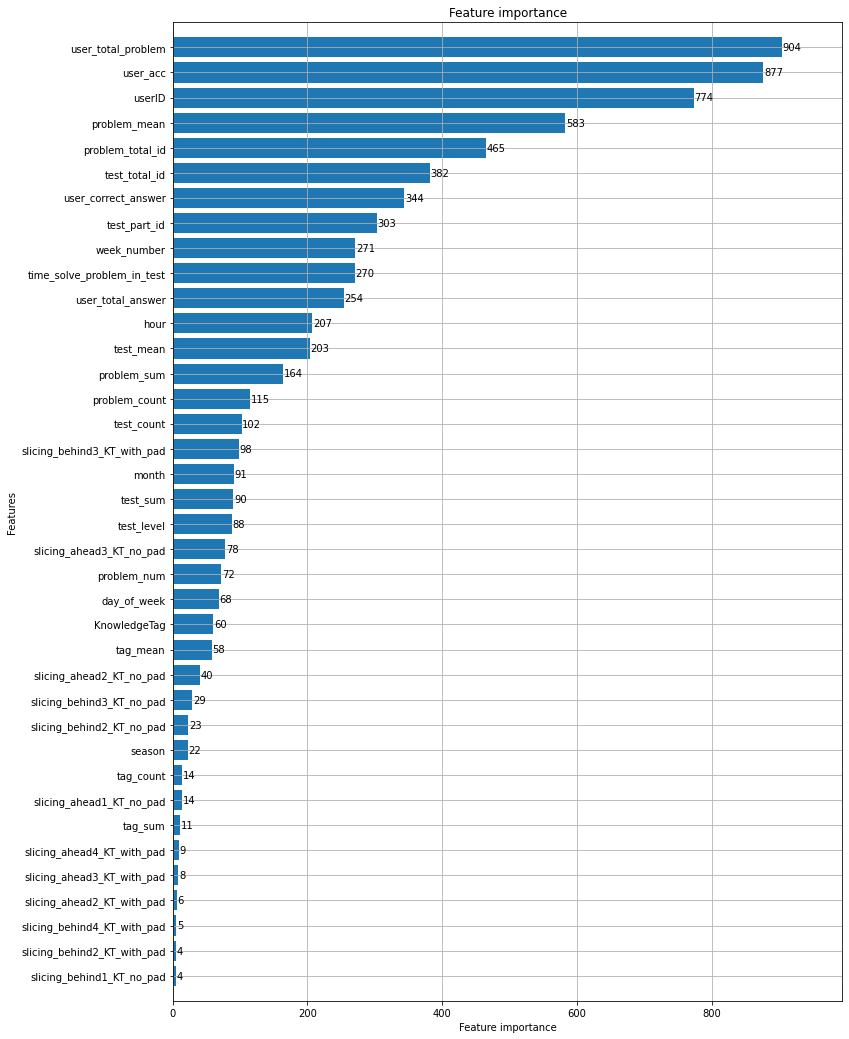

In [39]:
# load_model = joblib.load('/opt/p4-dkt-freshtomato/models/5-fold_optuna_all_train_userid_lgbm/4fold/lgb.pkl')
load_model = models_list[0]
# INSTALL MATPLOTLIB IN ADVANCE
from matplotlib import pylab as plt
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(load_model, title=,max_num_features=50, height=0.8, ax=ax)
plt.show()

In [47]:
df_feature_importance = pd.DataFrame(load_model.feature_importance(), index=load_model.feature_name(),columns=['feature_importance'])
df_feature_importance.sort_values(by=['feature_importance'],ascending=False)

,feature_importance
user_total_problem,904
user_acc,877
userID,774
problem_mean,583
problem_total_id,465
test_total_id,382
user_correct_answer,344
test_part_id,303
week_number,271
time_solve_problem_in_test,270


In [127]:
### Visualize study history to analayze the hyperparams-performance relationship

optuna.visualization.plot_optimization_history(study)   #Optimization history
#optuna.visualization.plot_intermediate_values(study)   #Visualize pruning history
#optuna.visualization.plot_slice(study)    #Visualize plot slice
#optuna.visualization.plot_contour(study)    #Visualize plot contour (변수들 pairwise plot => 두 모수의 상호작용효과 확인)
#optuna.visualization.plot_parallel_coordinate(study)   #Visualize parallel_coordinate


ImportError: Plotly is not available. Please install plotly to use this feature. Plotly can be installed by executing `$ pip install plotly`. For further information, please refer to the installation guide of plotly. (The actual import error is as follows: No module named 'plotly')